In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1881 entries, 0 to 1880
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   startdate    1881 non-null   datetime64[ns]
 1   answer_code  1881 non-null   object        
 2   sentiment    1881 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 44.2+ KB


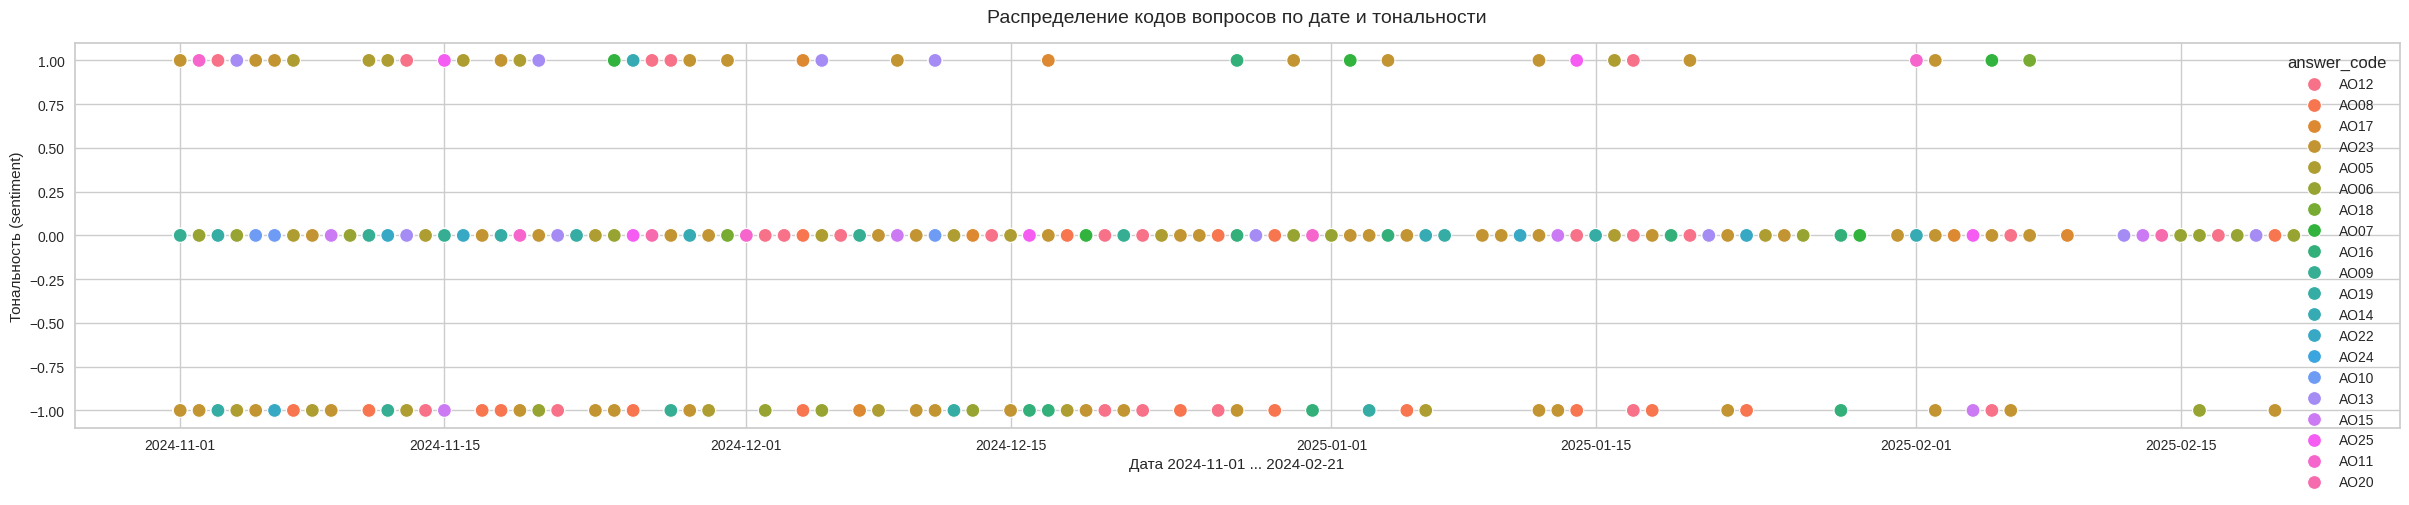


Характеристики числовых значений датасета:

                            startdate  answer_code    sentiment
count                           1881  1881.000000  1881.000000
mean   2024-11-30 08:05:21.531100672     0.082328    -0.056885
min              2024-11-01 00:00:00     0.011696    -1.000000
25%              2024-11-09 00:00:00     0.035619     0.000000
50%              2024-11-18 00:00:00     0.066454     0.000000
75%              2024-12-13 00:00:00     0.137693     0.000000
max              2025-02-21 00:00:00     0.161085     1.000000
std                              NaN     0.051343     0.393372


In [21]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
import time

# Игнорирование предупреждений (опционально)
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('/content/drive/MyDrive/Data-Science/my-hw-6/dataset_surv_analyze/surv_analyze.csv')

df = df.dropna()

# Преобразование дат в корректный формат datetime64[ns]
df['startdate'] = df['startdate'].astype("datetime64[ns]")

df.info()

plt.figure(figsize = (30, 5));
plt.title('Распределение кодов вопросов по дате и тональности', fontsize=14, pad=15)
sns.scatterplot(x=df['startdate'], y=df['sentiment'], data=df, hue='answer_code', s=100)
plt.xlabel('Дата 2024-11-01 ... 2024-02-21')
plt.ylabel('Тональность (sentiment)')
plt.show()


# One-Hot Encoding (OHE)
answer_code = pd.get_dummies(df["answer_code"], dtype="int64")  # Convert "answer_code" with text obj value to "AO05", "AO06" etc. with 1 or 0 value
df_OHE = pd.concat([df, answer_code], axis=1)
df_OHE.drop("answer_code", axis=1, inplace=True)


# Frequency Encoding of 'answer_code'
frequency = df['answer_code'].value_counts(normalize=True)
df['answer_code'] = df['answer_code'].map(frequency)

print('\nХарактеристики числовых значений датасета:\n\n',df.describe())

<Axes: title={'center': 'Корреляционная матрица 1. One-Hot Encoding (OHE) кодов опроса'}>

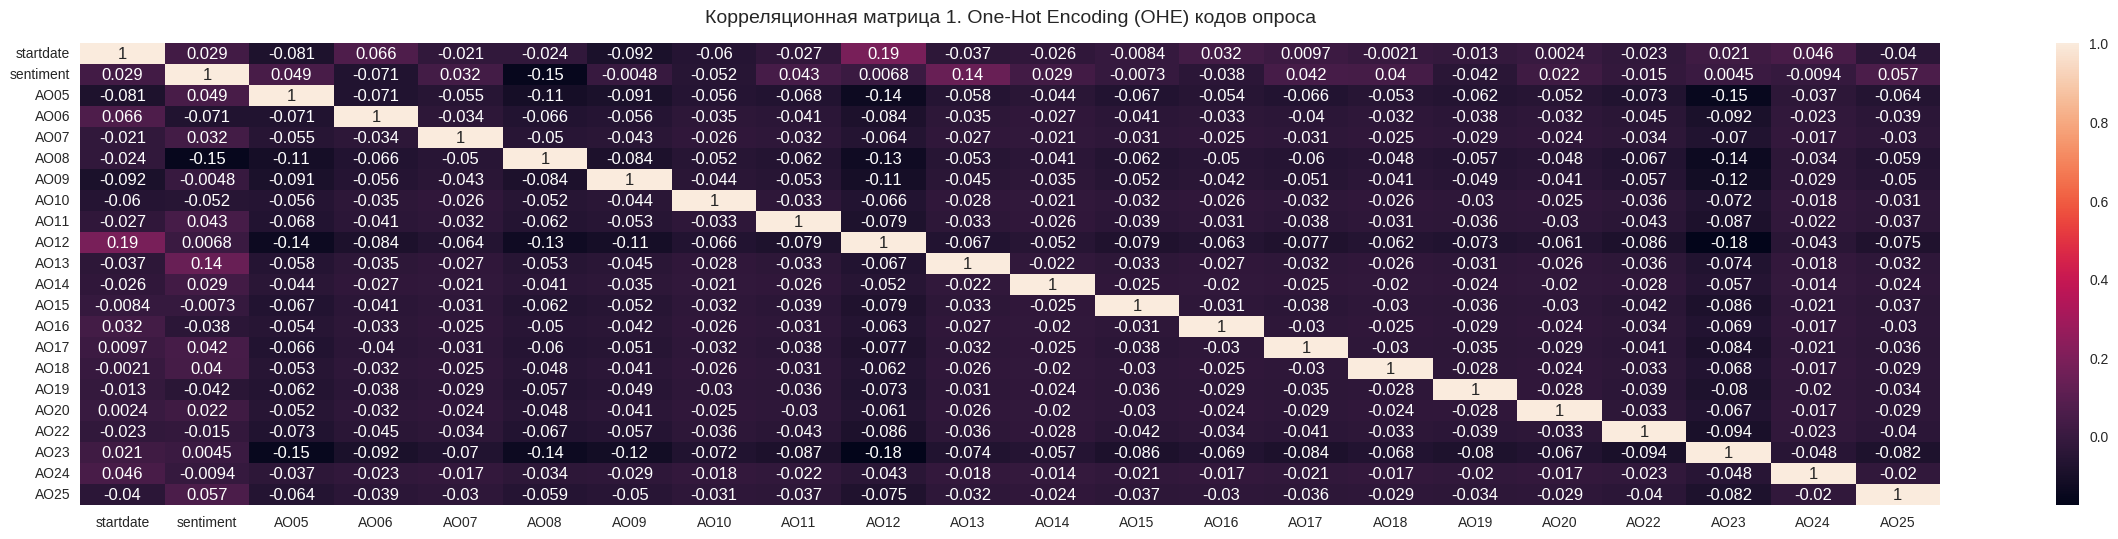

In [309]:
#Корреляционная матрица 1. One-Hot Encoding (OHE) кодов опроса
plt.figure(figsize = (30, 6));
plt.title('Корреляционная матрица 1. One-Hot Encoding (OHE) кодов опроса', fontsize=14, pad=15)
sns.heatmap(df_OHE.corr(),annot=True)

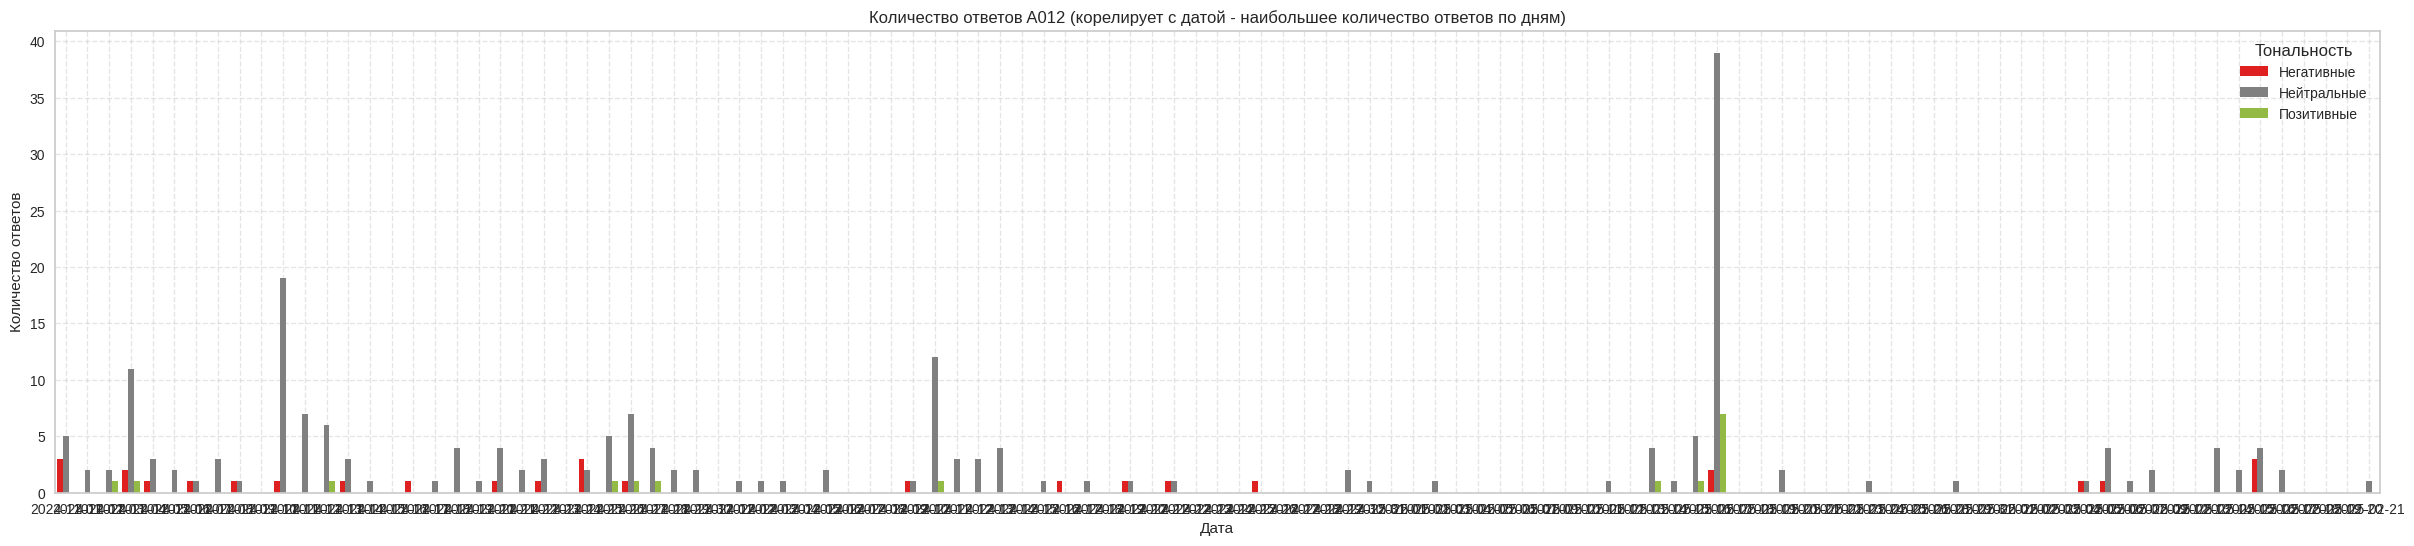

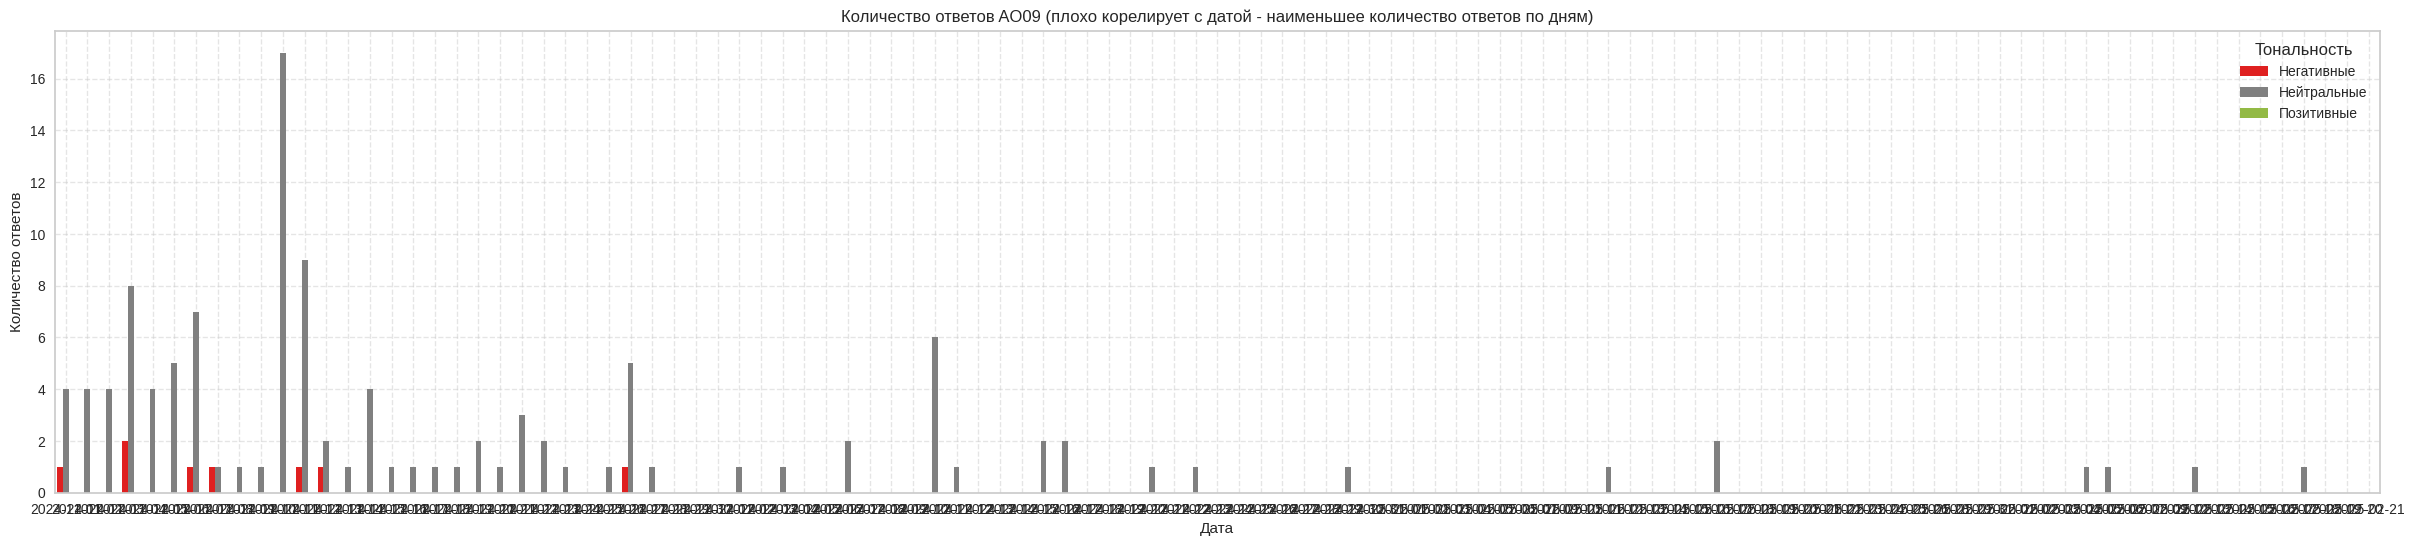

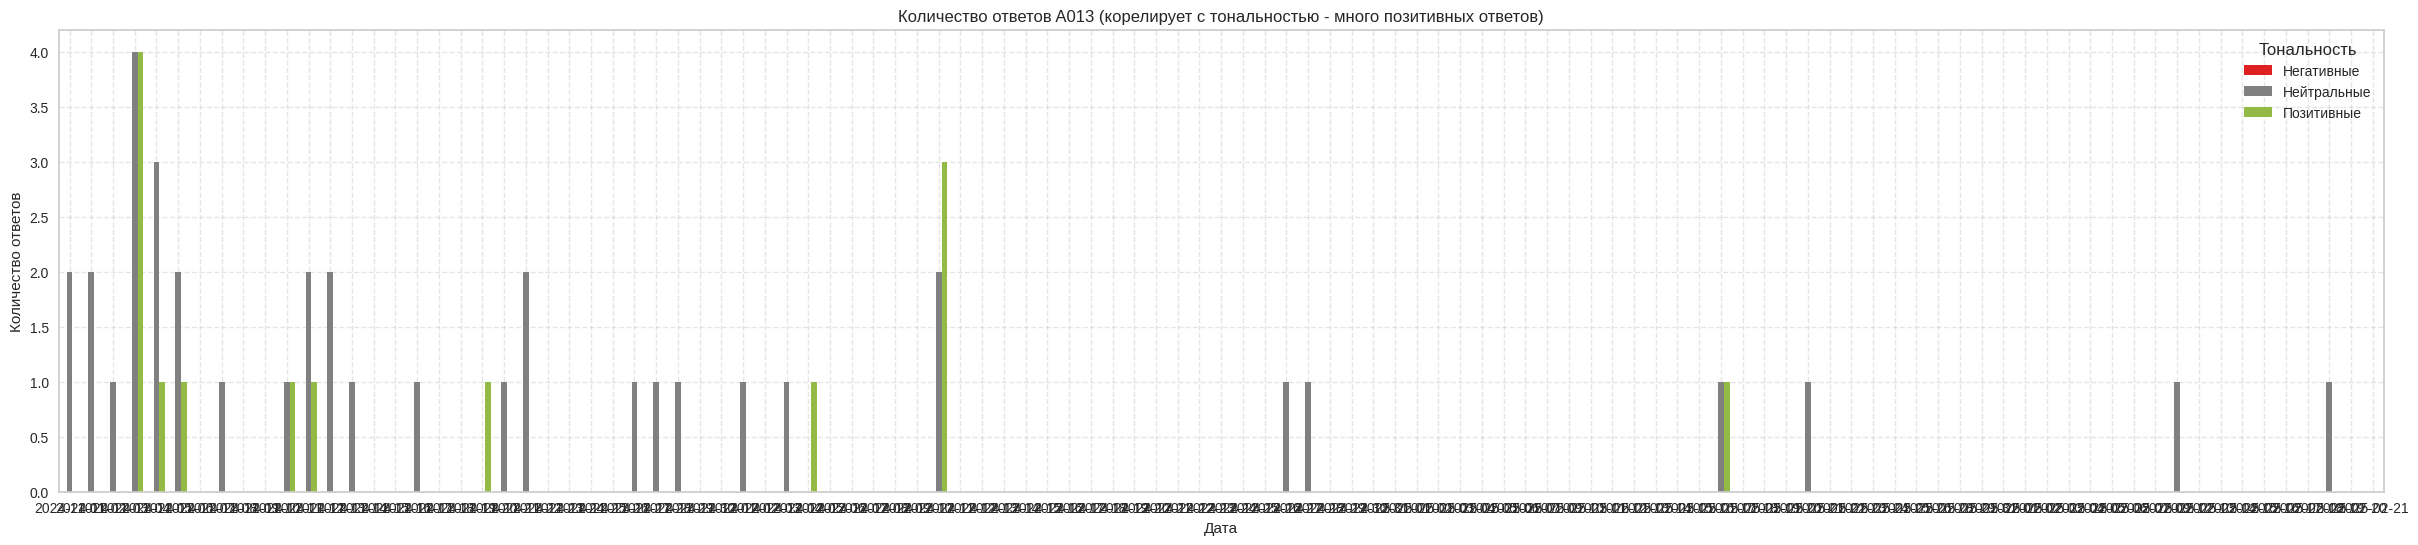

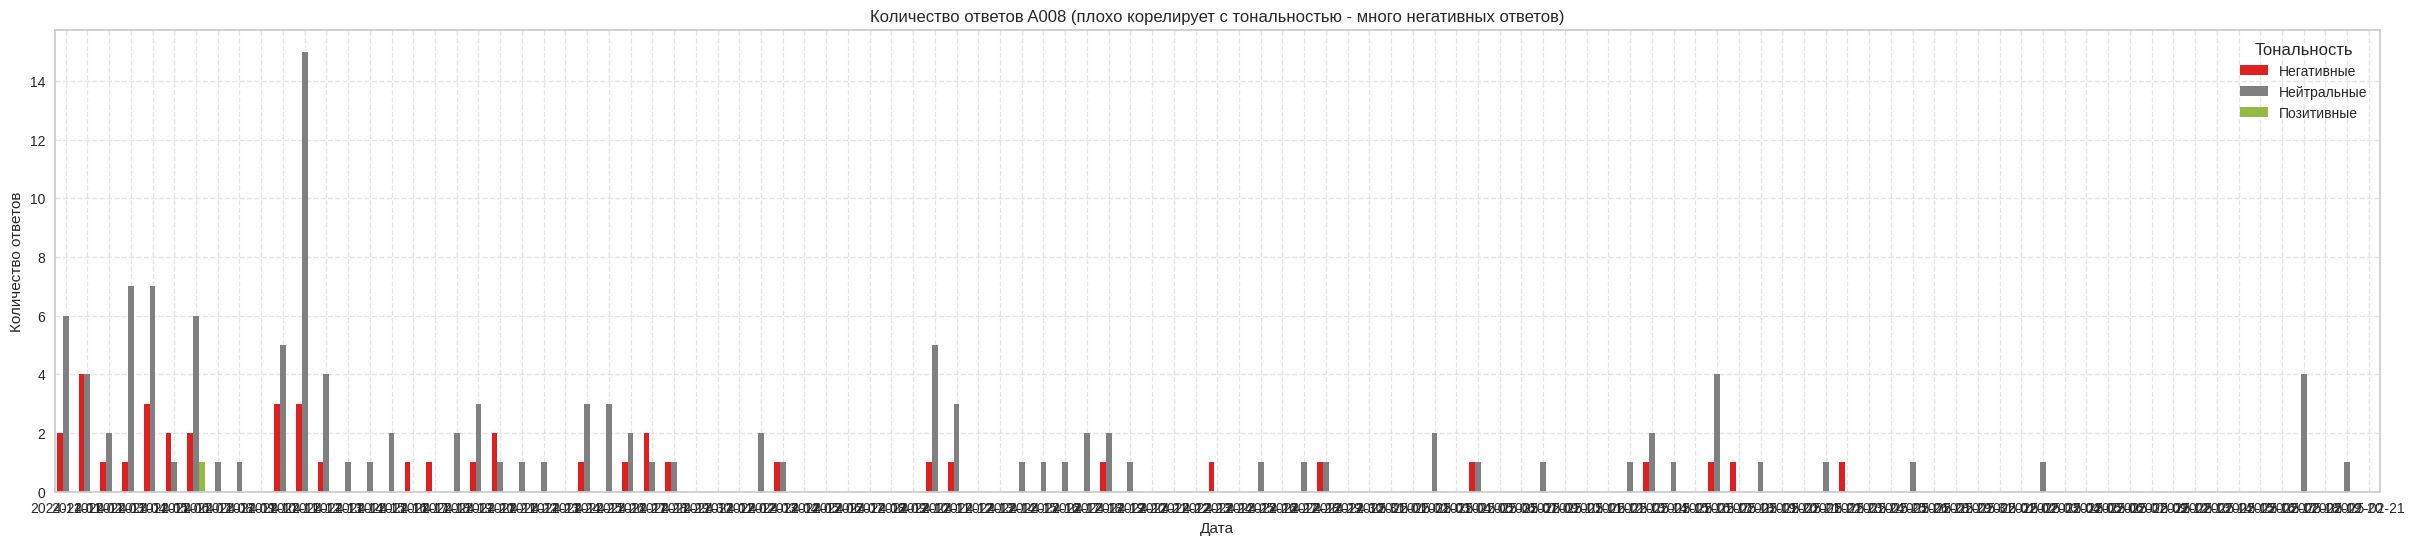

In [313]:
# Наиболее интересные для анализа вопросы A012 (корелирует с датой), AO09 (плохо корелирует с датой), A013 (корелирует с тональностью), A008 (плохо корелирует с тональностью)
plt.figure(figsize = (30, 6));
ax = sns.barplot(x="startdate", y="AO12", data=df_OHE,
             hue='sentiment',
             ci=None,
             palette=['red', 'grey', 'yellowgreen'],
             estimator='sum').set(title='Количество ответов A012 (корелирует с датой - наибольшее количество ответов по дням)', xlabel='Дата', ylabel='Количество ответов');
plt.grid(linestyle='--', alpha=0.5)
plt.legend(title='Тональность', loc='upper right', labels=['Негативные', 'Нейтральные', 'Позитивные'])
plt.figure(figsize = (30, 6));
ax = sns.barplot(x="startdate", y="AO09", data=df_OHE,
             hue='sentiment',
             ci=None,
             palette=['red', 'grey', 'yellowgreen'],
             estimator='sum').set(title='Количество ответов AO09 (плохо корелирует с датой - наименьшее количество ответов по дням)', xlabel='Дата', ylabel='Количество ответов');
plt.grid(linestyle='--', alpha=0.5)
plt.legend(title='Тональность', loc='upper right', labels=['Негативные', 'Нейтральные', 'Позитивные'])
plt.figure(figsize = (30, 6));
ax = sns.barplot(x="startdate", y="AO13", data=df_OHE,
             hue='sentiment',
             ci=None,
             palette=['red', 'grey', 'yellowgreen'],
             estimator='sum').set(title='Количество ответов A013 (корелирует с тональностью - много позитивных ответов)', xlabel='Дата', ylabel='Количество ответов');
plt.grid(linestyle='--', alpha=0.5)
plt.legend(title='Тональность', loc='upper right', labels=['Негативные', 'Нейтральные', 'Позитивные'])
plt.figure(figsize = (30, 6));
ax = sns.barplot(x="startdate", y="AO08", data=df_OHE,
             hue='sentiment',
             ci=None,
             palette=['red', 'grey', 'yellowgreen'],
             estimator='sum').set(title='Количество ответов A008 (плохо корелирует с тональностью - много негативных ответов)', xlabel='Дата', ylabel='Количество ответов');
plt.grid(linestyle='--', alpha=0.5)
plt.legend(title='Тональность', loc='upper right', labels=['Негативные', 'Нейтральные', 'Позитивные'])
plt.show()

,startdate,answer_code,sentiment
0,2024-11-01,0.137693,-1
1,2024-11-01,0.089314,-1
2,2024-11-01,0.035619,0
3,2024-11-01,0.161085,0
4,2024-11-01,0.104200,0


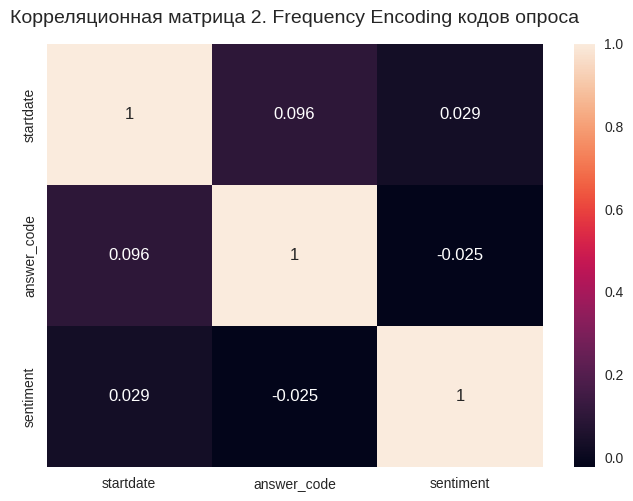

In [22]:
#Корреляционная матрица 2. Frequency Encoding  кодов опроса ('answer_code')
plt.title('Корреляционная матрица 2. Frequency Encoding кодов опроса', fontsize=14, pad=15)
sns.heatmap(df.corr(),annot=True)
df.head()

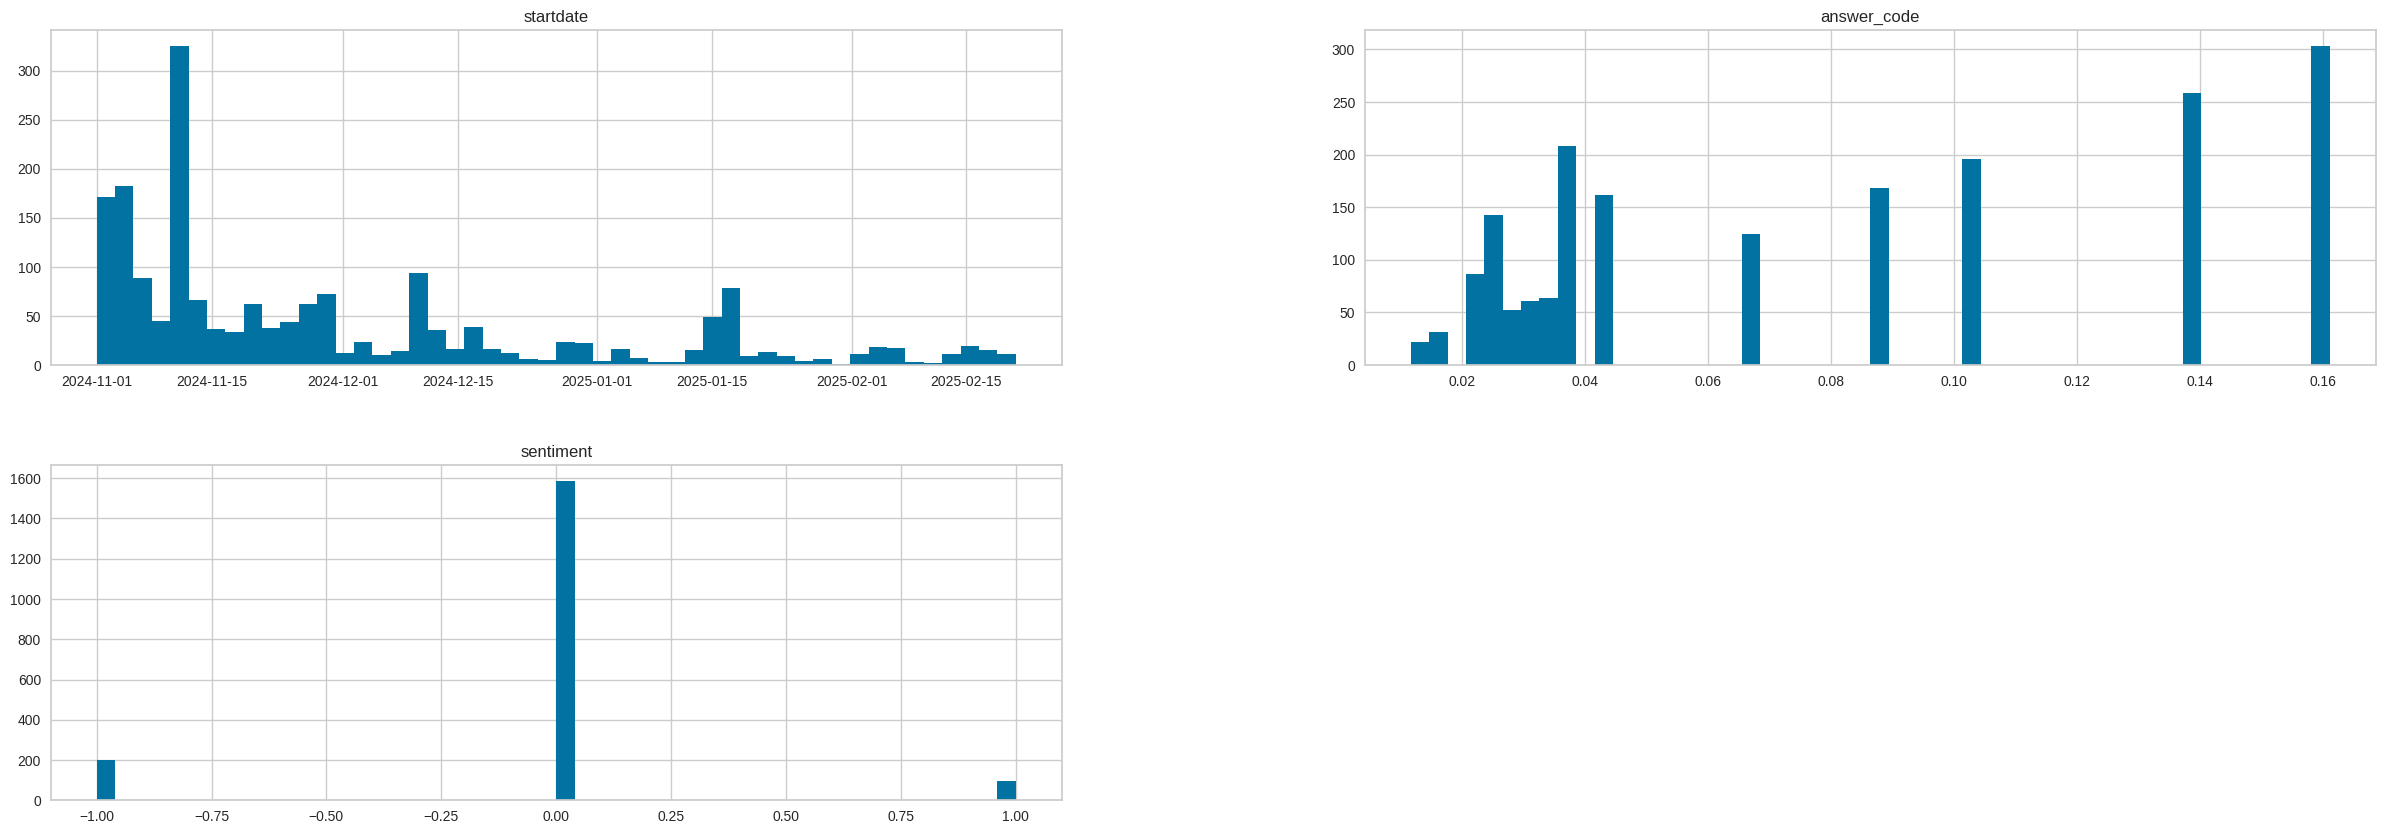

In [15]:
# Гистограммы распределения данных
df.hist(bins=50, figsize=(30,10))
plt.show()

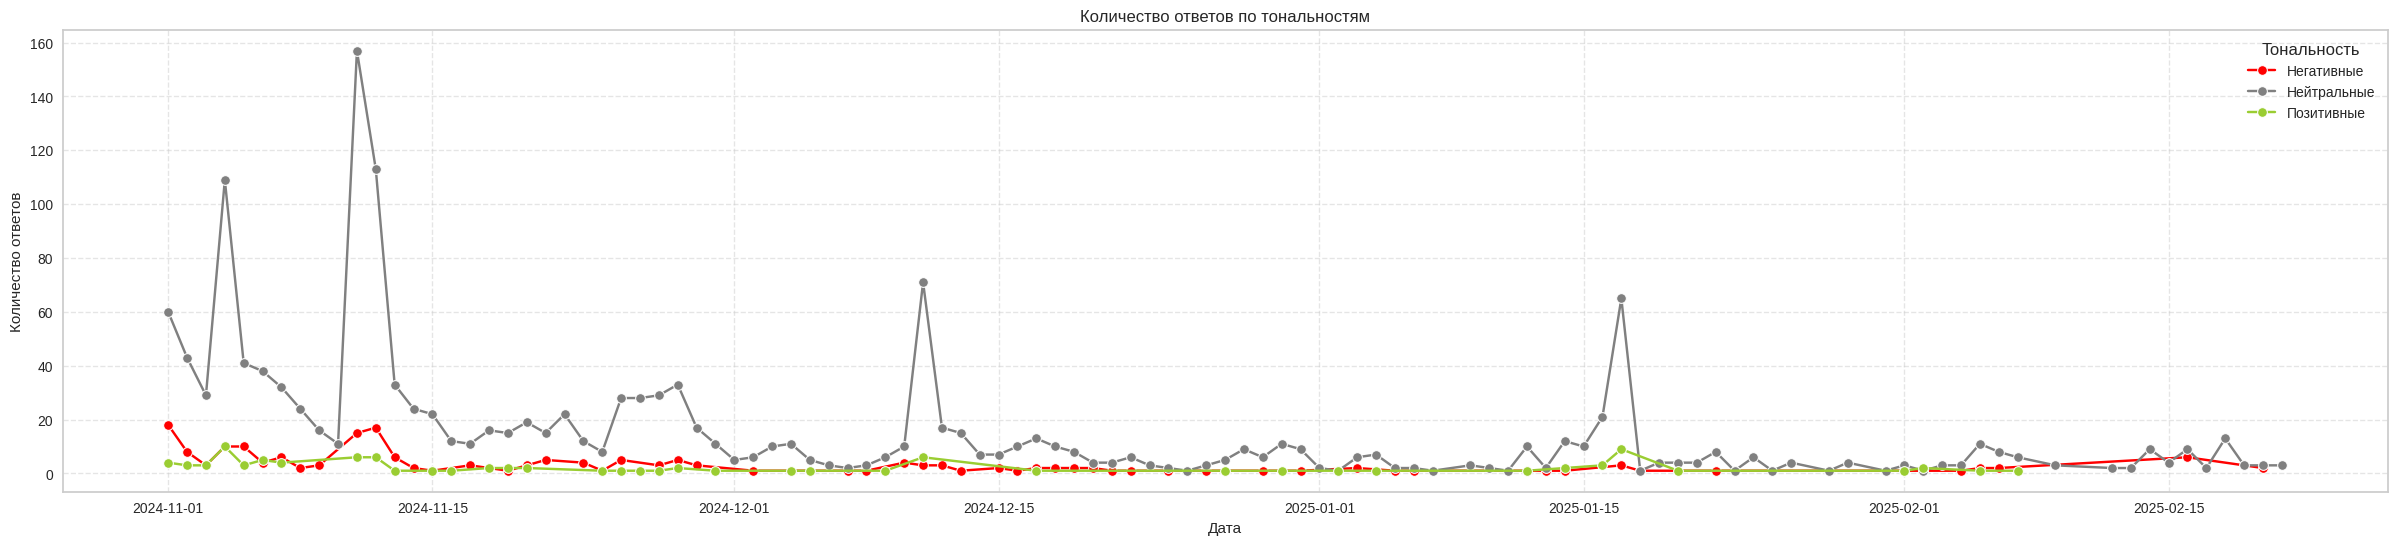

In [291]:
plt.figure(figsize = (30, 6));
ax = sns.lineplot(x="startdate", y=len("answer_code")/11, data=df,
             hue='sentiment',
             ci=None,
             marker='o',
             palette=['red', 'grey', 'yellowgreen'],
             estimator='sum').set(title='Количество ответов по тональностям', xlabel='Дата', ylabel='Количество ответов');
plt.grid(linestyle='--', alpha=0.5)
plt.legend(title='Тональность', loc='upper right', labels=['Негативные', 'Нейтральные', 'Позитивные'])
plt.show()


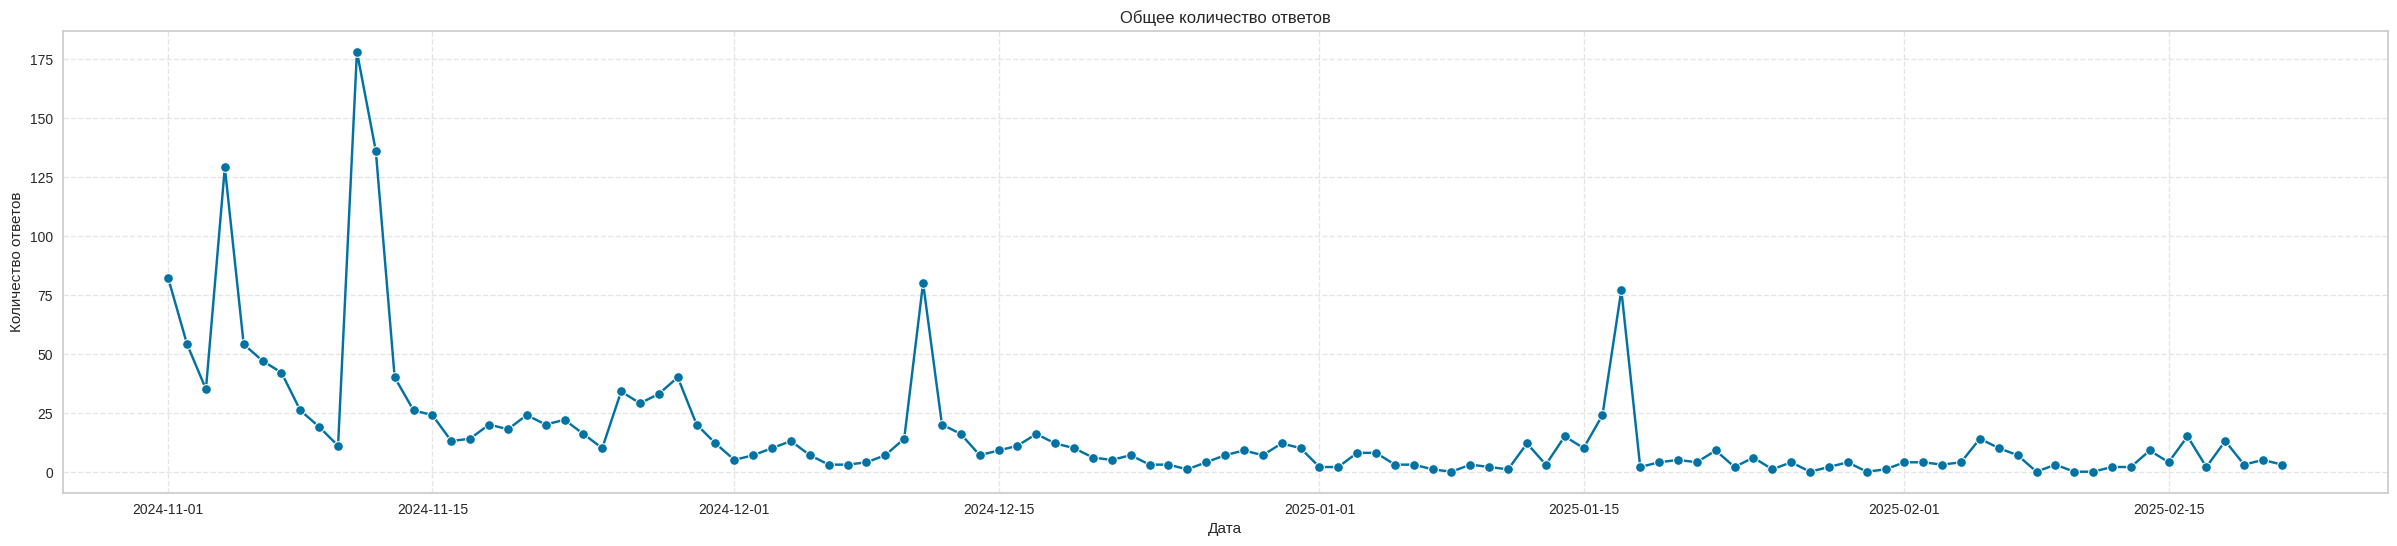

In [23]:
#Создаем выборку для временного ряда

# Group the DataFrame by date using Day frequency
grouped_data = df.groupby(pd.Grouper(key='startdate', freq='D'))

# Perform an operation on the grouped data
result = grouped_data['answer_code'].size()

# Convert Pandas Series object to DataFrame
df_sum_answer_to_date = result.to_frame()

df_sum_answer_to_date = df_sum_answer_to_date.rename(columns={'answer_code': 'answer_count'})

plt.figure(figsize = (30, 6));
sns.lineplot(x="startdate", y="answer_count", data=df_sum_answer_to_date,
             ci=None,
             marker='o').set(title='Общее количество ответов', xlabel='Дата', ylabel='Количество ответов');
plt.grid(linestyle='--', alpha=0.5);
plt.show()

In [59]:
df_sum_answer_to_date.info()
df_sum_answer_to_date.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113 entries, 2024-11-01 to 2025-02-21
Freq: D
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   answer_count  113 non-null    int64
dtypes: int64(1)
memory usage: 1.8 KB


,answer_count
startdate,
2024-11-01,82
2024-11-02,54
2024-11-03,35
2024-11-04,129
2024-11-05,54


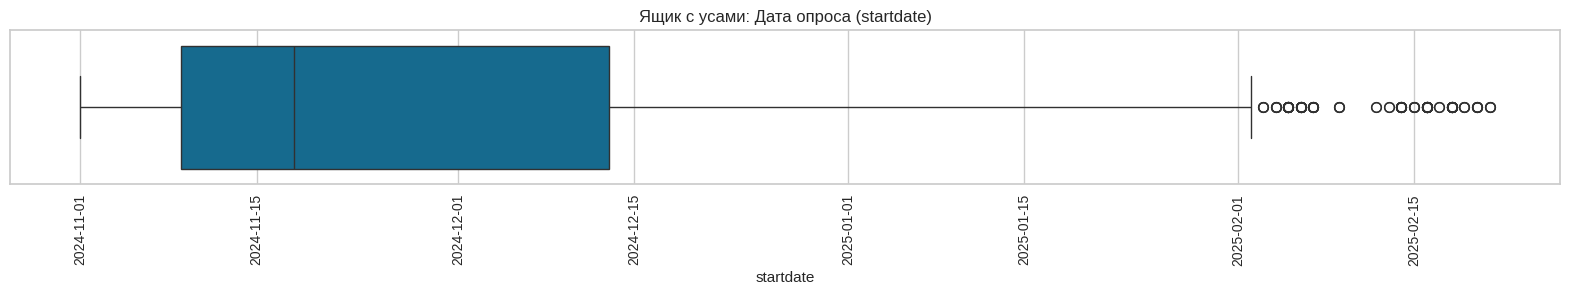

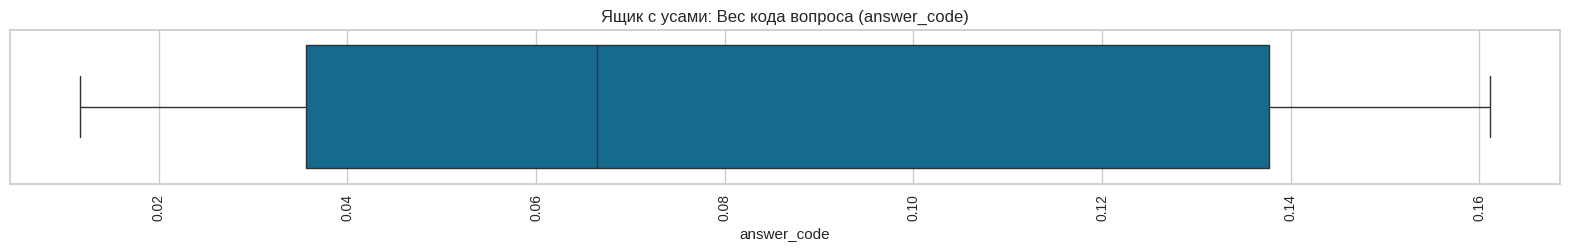

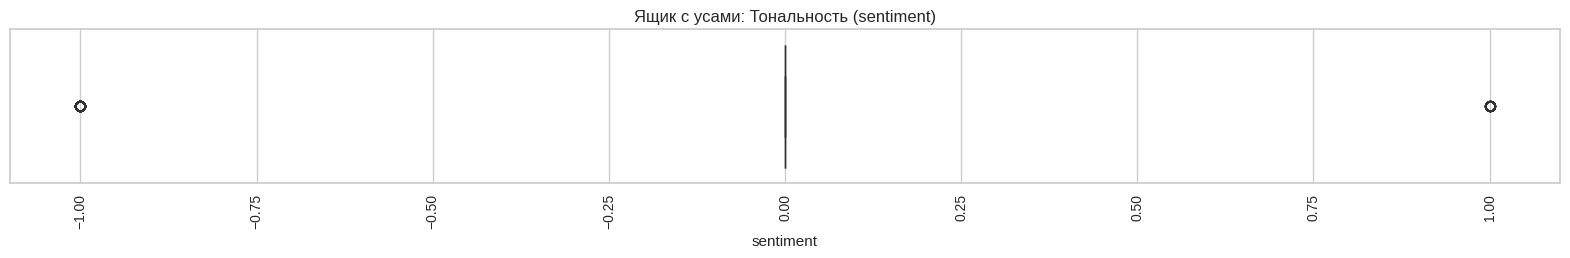

In [10]:
# Усы для данных 1
cols = df
titles = ['Дата опроса', 'Вес кода вопроса', 'Тональность']
i=0
for col in cols:
  plt.figure(figsize=(20, 2))
  sns.boxplot(x=col, data=df)
  plt.title(f'Ящик с усами: {titles[i]} ({col})')
  plt.xticks(rotation=90)
  plt.show()
  i=i+1

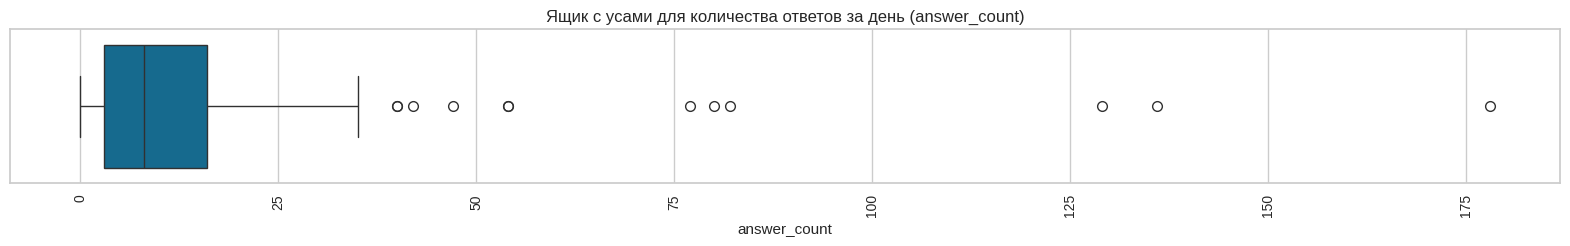

In [11]:
# Усы для данных 2
cols = df_sum_answer_to_date
for col in cols:
  plt.figure(figsize=(20, 2))
  sns.boxplot(x=col, data=df_sum_answer_to_date)
  plt.title(f'Ящик с усами для количества ответов за день ({col})')
  plt.xticks(rotation=90)
  plt.show()

In [145]:
# Временные ряды
# Используем подготовленную выше выборку df_sum_answer_to_date c полями 'startdate', 'answer_count'
train = df_sum_answer_to_date[:102]
test = df_sum_answer_to_date[103:]

In [ ]:
!pip install pycaret

In [146]:
from pycaret.time_series import *
# Настройка эксперимента
exp = TSForecastingExperiment()
exp.setup(data=train, target='answer_count', fh = 1, session_id=123)

,Description,Value
0,session_id,123
1,Target,answer_count
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(102, 1)"
5,Transformed data shape,"(102, 1)"
6,Transformed train set shape,"(101, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [147]:
# Сравнение моделей и выбор наилучшей
best_model = exp.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
exp_smooth,Exponential Smoothing,0.1062,0.0540,1.5949,1.5949,362748462767371.0625,1.2375,0.1133
theta,Theta Forecaster,0.1716,0.0872,2.5833,2.5833,7039486837098515.0000,0.8692,0.0800
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.2124,0.1079,3.1839,3.1839,9138815784442608.0000,1.3351,0.4000
croston,Croston,0.2313,0.1175,3.4698,3.4698,9522311156432092.0000,0.9415,0.0500
snaive,Seasonal Naive Forecaster,0.2432,0.1237,3.6667,3.6667,6004799503160661.0000,1.2619,0.1400
arima,ARIMA,0.2605,0.1324,3.9171,3.9171,5896660914563095.0000,1.6401,0.1433
ets,ETS,0.2641,0.1341,3.9600,3.9600,5740666958513900.0000,1.4243,0.2200
naive,Naive Forecaster,0.2884,0.1465,4.3333,4.3333,10508399130531158.0000,1.4510,0.0867
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.2888,0.1467,4.3327,4.3327,6331300391427563.0000,1.4493,0.1233
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,0.3530,0.1796,5.3262,5.3262,9047523845994386.0000,1.3745,0.1100


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

In [201]:
# Обучение выбранной модели
final_model = exp.create_model(best_model)
print('\nЛучшая модель:', best_model)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2025-02-06,0.1328,0.0676,2.0097,2.0097,0.2871,0.2511
1,2025-02-07,0.0161,0.0082,0.2416,0.2416,1088245388302112.0000,2.0000
2,2025-02-08,0.1699,0.0861,2.5333,2.5333,0.8444,1.4615
Mean,NaT,0.1062,0.0540,1.5949,1.5949,362748462767371.0625,1.2375
SD,NaT,0.0655,0.0332,0.9805,0.9805,513003795775607.0000,0.7314


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Лучшая модель: ExponentialSmoothing(seasonal='add', sp=7, trend='add')


In [202]:
# График диагностики модели
exp.plot_model(plot = 'diagnostics')

In [203]:
exp.plot_model(final_model, plot = 'forecast', data_kwargs = {'fh' : 16})

In [204]:
# Предсказания
final_best = exp.finalize_model(final_model)
exp.predict_model(final_model, fh = 16)

,y_pred
2025-02-10,3.7519
2025-02-11,4.6173
2025-02-12,7.6807
2025-02-13,4.8225
2025-02-14,10.1539
2025-02-15,-0.6442
2025-02-16,0.0282
2025-02-17,3.0822
2025-02-18,3.9476
2025-02-19,7.0109


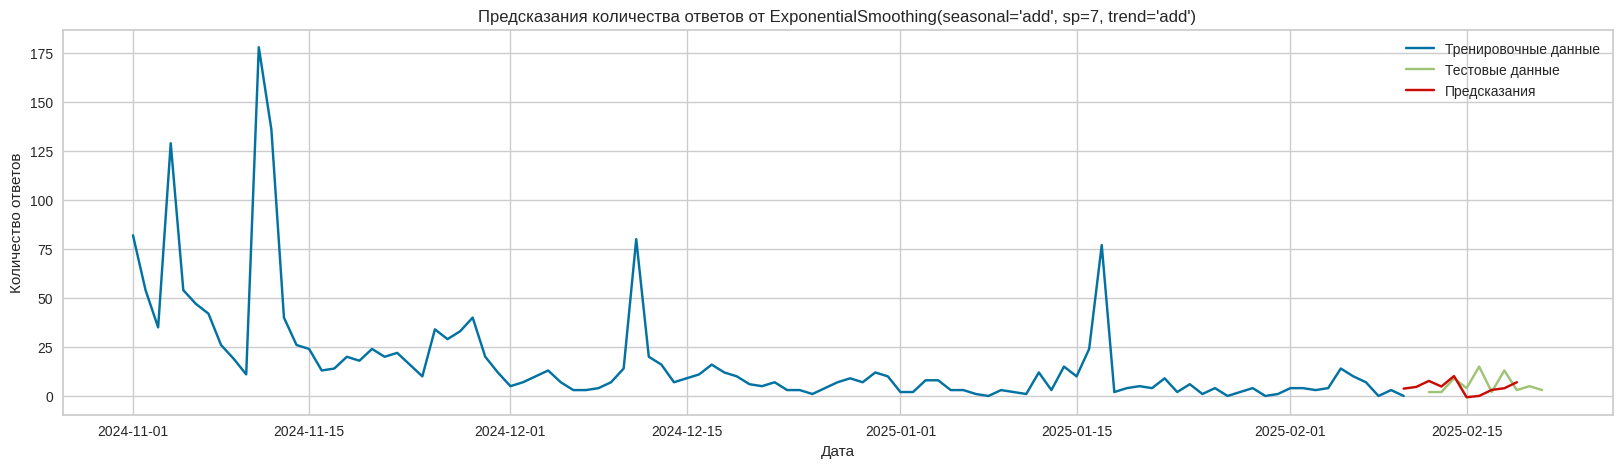

In [205]:
# Получение предсказаний для тестового набора данных
predictions_best = exp.predict_model(final_model, fh=len(test))
# Построение графика фактических данных и предсказаний
plt.figure(figsize=(20, 5))
plt.plot(train.index, train['answer_count'], label='Тренировочные данные')
plt.plot(test.index, test['answer_count'], label='Тестовые данные')
plt.plot(predictions_best.index, predictions_best, label='Предсказания')
plt.xlabel('Дата')
plt.ylabel('Количество ответов')
plt.title(f'Предсказания количества ответов от {best_model}')
plt.legend()
plt.show()

In [206]:
# Обучение других моделей для сравнения
theta_model = exp.create_model('theta')
print('\nВыбрана модель:', 'Theta Forecaster')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2025-02-06,0.1632,0.0831,2.4696,2.4696,0.3528,0.4284
1,2025-02-07,0.3119,0.1586,4.6892,4.6892,21118460511295544.0000,2.0000
2,2025-02-08,0.0396,0.0201,0.5910,0.5910,0.1970,0.1793
Mean,NaT,0.1716,0.0872,2.5833,2.5833,7039486837098515.0000,0.8692
SD,NaT,0.1113,0.0566,1.6750,1.6750,9955337757171602.0000,0.8060


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Выбрана модель: Theta Forecaster


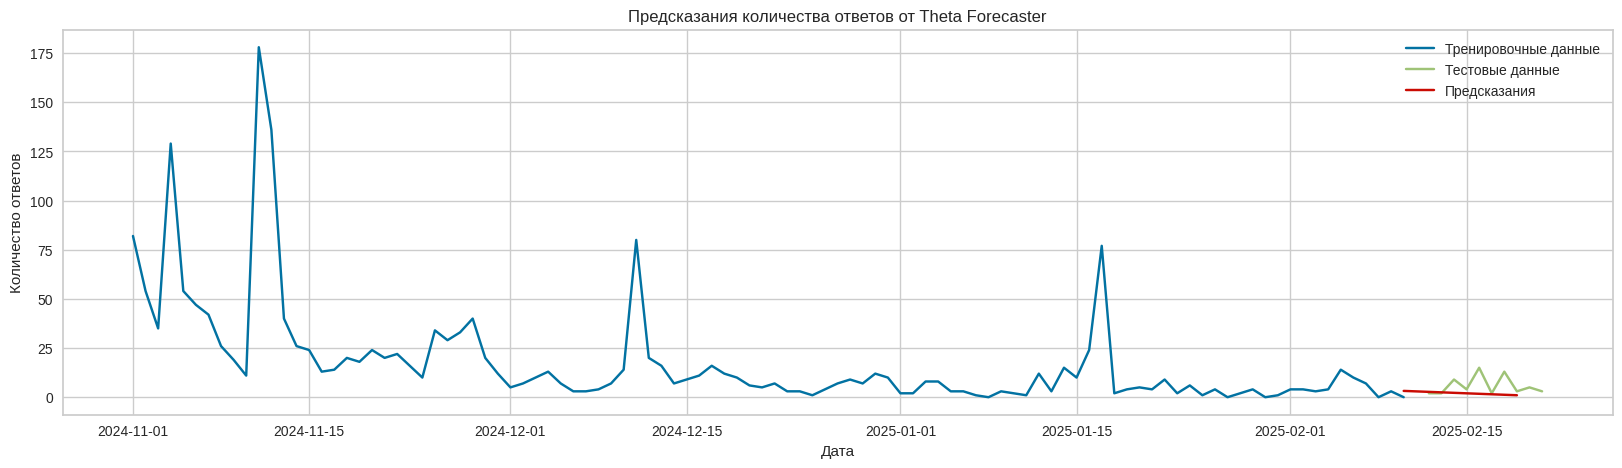

In [207]:
# Получение предсказаний для тестового набора данных
predictions = exp.predict_model(theta_model, fh=len(test))
# Построение графика фактических данных и предсказаний
plt.figure(figsize=(20, 5))
plt.plot(train.index, train['answer_count'], label='Тренировочные данные')
plt.plot(test.index, test['answer_count'], label='Тестовые данные')
plt.plot(predictions.index, predictions, label='Предсказания')
plt.xlabel('Дата')
plt.ylabel('Количество ответов')
plt.title('Предсказания количества ответов от Theta Forecaster')
plt.legend()
plt.show()

In [208]:
arima_model = exp.create_model('arima')
print('\nВыбрана модель:', 'Arima')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2025-02-06,0.2916,0.1484,4.4118,4.4118,0.6303,0.9202
1,2025-02-07,0.2613,0.1328,3.9280,3.9280,17689982743689284.0000,2.0000
2,2025-02-08,0.2288,0.1160,3.4117,3.4117,1.1372,2.0000
Mean,NaT,0.2605,0.1324,3.9171,3.9171,5896660914563095.0000,1.6401
SD,NaT,0.0256,0.0132,0.4083,0.4083,8339137838090466.0000,0.5090


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Выбрана модель: Arima


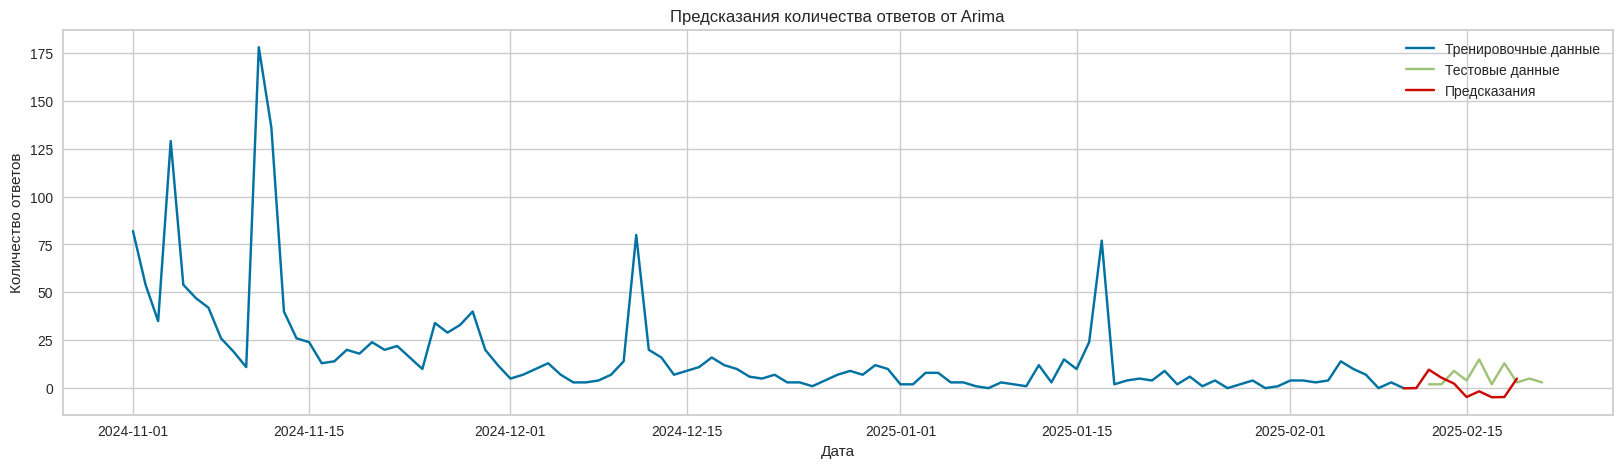

In [209]:
# Получение предсказаний для тестового набора данных
predictions = exp.predict_model(arima_model, fh=len(test))
# Построение графика фактических данных и предсказаний
plt.figure(figsize=(20, 5))
plt.plot(train.index, train['answer_count'], label='Тренировочные данные')
plt.plot(test.index, test['answer_count'], label='Тестовые данные')
plt.plot(predictions.index, predictions, label='Предсказания')
plt.xlabel('Дата')
plt.ylabel('Количество ответов')
plt.title('Предсказания количества ответов от Arima')
plt.legend()
plt.show()

In [210]:
lightgbm_model = exp.create_model('lightgbm_cds_dt')
print('\nВыбрана модель:', 'Light Gradient Boosting w/ Cond. Deseasonalize & Detrending')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2025-02-06,0.1052,0.0535,1.5915,1.5915,0.2274,0.2041
1,2025-02-07,0.4783,0.2431,7.1901,7.1901,32381537428413056.0000,2.0000
2,2025-02-08,0.5071,0.2571,7.5625,7.5625,2.5208,2.0000
Mean,NaT,0.3635,0.1846,5.4480,5.4480,10793845809471020.0000,1.4014
SD,NaT,0.1831,0.0928,2.7312,2.7312,15264803133917914.0000,0.8466


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Выбрана модель: Light Gradient Boosting w/ Cond. Deseasonalize & Detrending


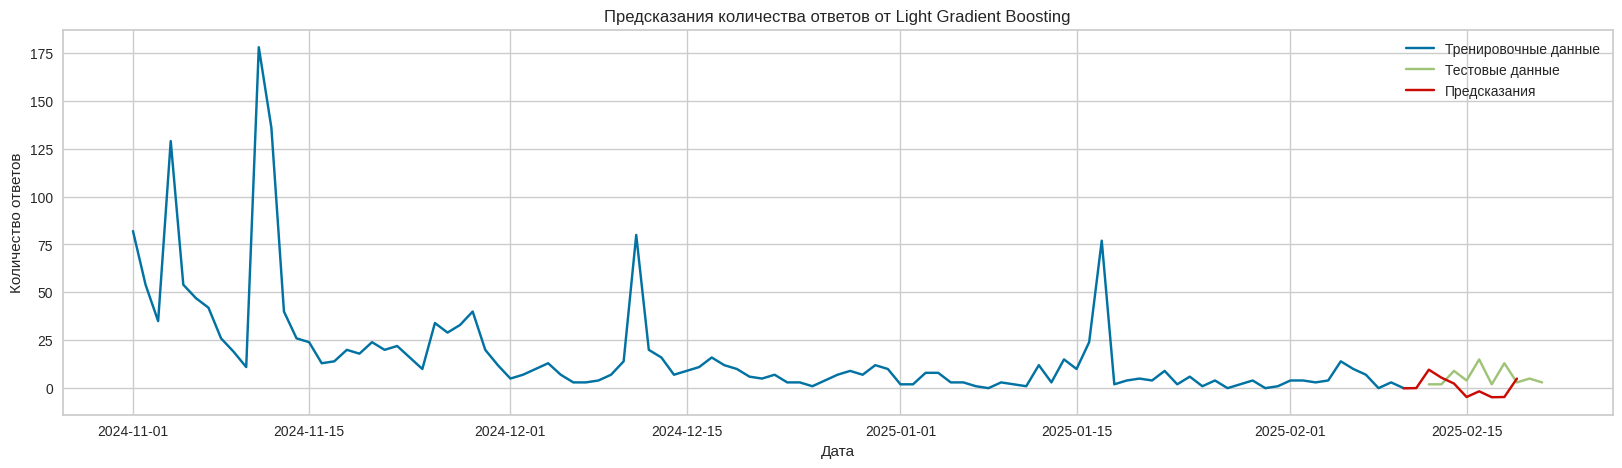

In [211]:
# Получение предсказаний для тестового набора данных
predictions = exp.predict_model(arima_model, fh=len(test))
# Построение графика фактических данных и предсказаний
plt.figure(figsize=(20, 5))
plt.plot(train.index, train['answer_count'], label='Тренировочные данные')
plt.plot(test.index, test['answer_count'], label='Тестовые данные')
plt.plot(predictions.index, predictions, label='Предсказания')
plt.xlabel('Дата')
plt.ylabel('Количество ответов')
plt.title('Предсказания количества ответов от Light Gradient Boosting')
plt.legend()
plt.show()

In [212]:
knn_cds_dt_model = exp.create_model('knn_cds_dt')
print('\nВыбрана модель:', 'K Neighbors w/ Cond. Deseasonalize & Detrending')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2025-02-06,0.1948,0.0992,2.9478,2.9478,0.4211,0.3479
1,2025-02-07,0.2806,0.1426,4.2175,4.2175,18993901174282688.0000,2.0000
2,2025-02-08,0.3911,0.1983,5.8328,5.8328,1.9443,2.0000
Mean,NaT,0.2888,0.1467,4.3327,4.3327,6331300391427563.0000,1.4493
SD,NaT,0.0803,0.0406,1.1806,1.1806,8953810881014945.0000,0.7788


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Выбрана модель: K Neighbors w/ Cond. Deseasonalize & Detrending


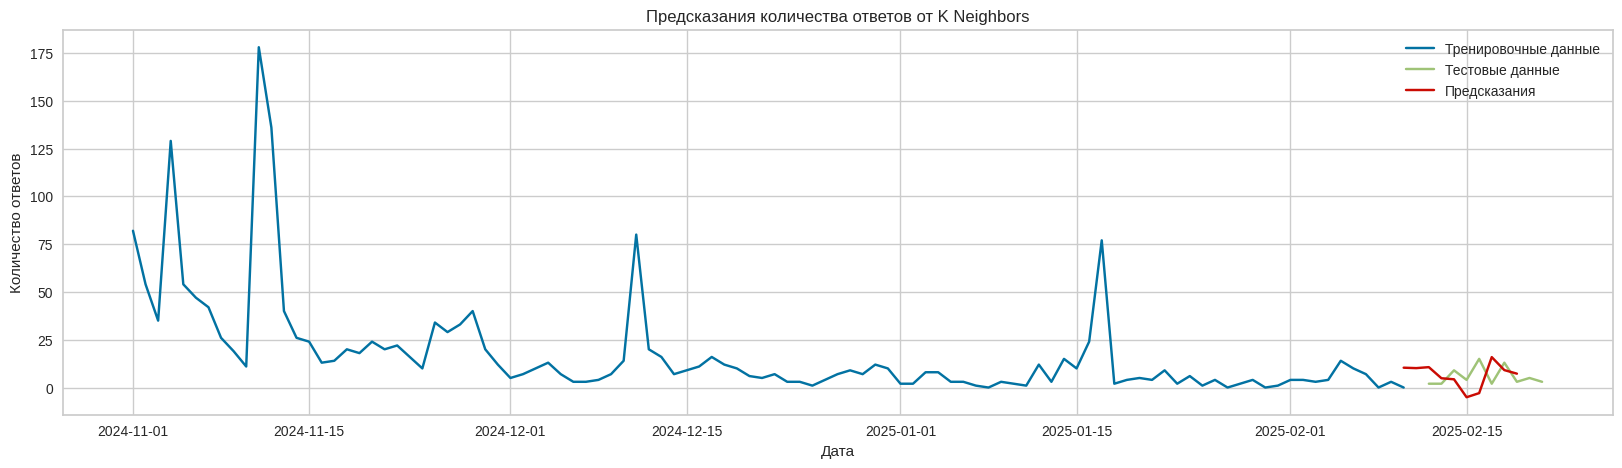

In [213]:
# Получение предсказаний для тестового набора данных
predictions = exp.predict_model(knn_cds_dt_model, fh=len(test))
# Построение графика фактических данных и предсказаний
plt.figure(figsize=(20, 5))
plt.plot(train.index, train['answer_count'], label='Тренировочные данные')
plt.plot(test.index, test['answer_count'], label='Тестовые данные')
plt.plot(predictions.index, predictions, label='Предсказания')
plt.xlabel('Дата')
plt.ylabel('Количество ответов')
plt.title('Предсказания количества ответов от K Neighbors')
plt.legend()
plt.show()

MAE: 3.21186
MSE: 22.828216714
R2: -0.08913247681297709


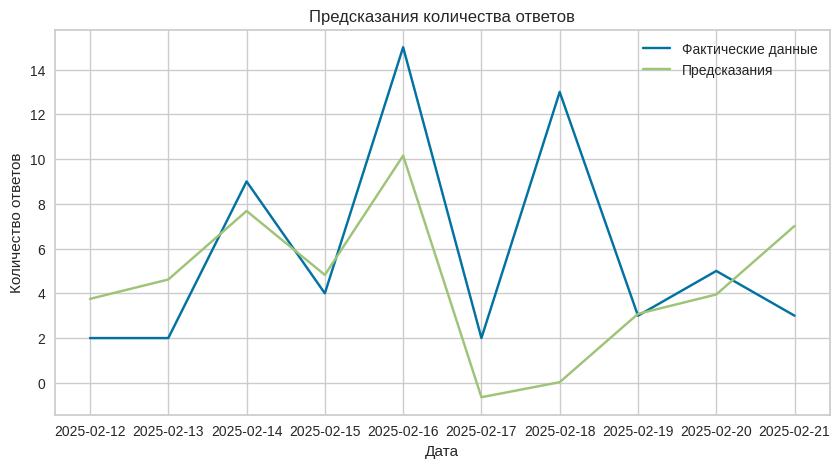

In [214]:
# Фактические значения
actual = test['answer_count'].values
# Предсказанные значения лучшей модели
predicted = predictions_best.values

# MAE
mae = mean_absolute_error(actual, predicted)
# MSE
mse = mean_squared_error(actual, predicted)
# R2
r2 = r2_score(actual, predicted)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2: {r2}")

# График фактических значений и предсказаний
plt.figure(figsize=(10, 5))
plt.plot(test.index, actual, label='Фактические данные')
plt.plot(test.index, predicted, label='Предсказания')
plt.xlabel('Дата')
plt.ylabel('Количество ответов')
plt.title('Предсказания количества ответов')
plt.legend()
plt.show()

In [216]:
# Фактические значения
actual = test['answer_count'].values.flatten()  # Преобразование в одномерный массив
# Предсказанные значения лучшей модели
predicted = predictions_best.values.flatten()  # Преобразование в одномерный массив

# Рассчет ошибок прогнозирования
residuals = actual - predicted

# Создание DataFrame для отображения значений и ошибок
results_df = pd.DataFrame({
    'Дата': test.index,
    'Фактические': actual,
    'Предсказанные': predicted,
    'Ошибка': residuals
})

# Отображение таблицы
print('Прогнозирование количества ответов')
print(results_df)

Прогнозирование количества ответов
        Дата  Фактические  Предсказанные   Ошибка
0 2025-02-12            2         3.7519  -1.7519
1 2025-02-13            2         4.6173  -2.6173
2 2025-02-14            9         7.6807   1.3193
3 2025-02-15            4         4.8225  -0.8225
4 2025-02-16           15        10.1539   4.8461
5 2025-02-17            2        -0.6442   2.6442
6 2025-02-18           13         0.0282  12.9718
7 2025-02-19            3         3.0822  -0.0822
8 2025-02-20            5         3.9476   1.0524
9 2025-02-21            3         7.0109  -4.0109


In [276]:
# Детекция аномалий

from pycaret.anomaly import *

# Настройка эксперимента аномалий на данных предсказаний
anom_exp = setup(data=pd.DataFrame(predictions_best), session_id=123, normalize=True)

# Создание и обучение модели аномалий
final_anomaly_model = create_model('iforest', fraction=0.25)
# contamination=0.05 по умолчанию. Доля выбросов (аномалий) в данных.0.05 указывает, что ожидается примерно 5% аномальных наблюдений в данных
# Параметром fraction=0.25 делаем contamination=0.25

print(final_anomaly_model)


# Предсказание аномалий
anomalies = predict_model(final_anomaly_model, data=pd.DataFrame(predictions_best))

# Объединение аномалий с тестовыми данными для визуализации
anomalies['Date'] = test.index
anomalies.set_index('Date', inplace=True)

print(anomalies)


,Description,Value
0,Session id,123
1,Original data shape,"(10, 1)"
2,Transformed data shape,"(10, 1)"
3,Numeric features,1
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Normalize,True
9,Normalize method,zscore


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

IForest(behaviour='new', bootstrap=False, contamination=0.25,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=123, verbose=0)
              y_pred  Anomaly  Anomaly_Score
Date                                        
2025-02-12 -0.221649        0      -0.146503
2025-02-13  0.055061        0      -0.146131
2025-02-14  1.034576        0      -0.054518
2025-02-15  0.120673        0      -0.130922
2025-02-16  1.825376        1       0.102652
2025-02-17 -1.627292        1       0.052607
2025-02-18 -1.412294        1       0.018173
2025-02-19 -0.435784        0      -0.071751
2025-02-20 -0.159074        0      -0.153509
2025-02-21  0.820409        0      -0.067720


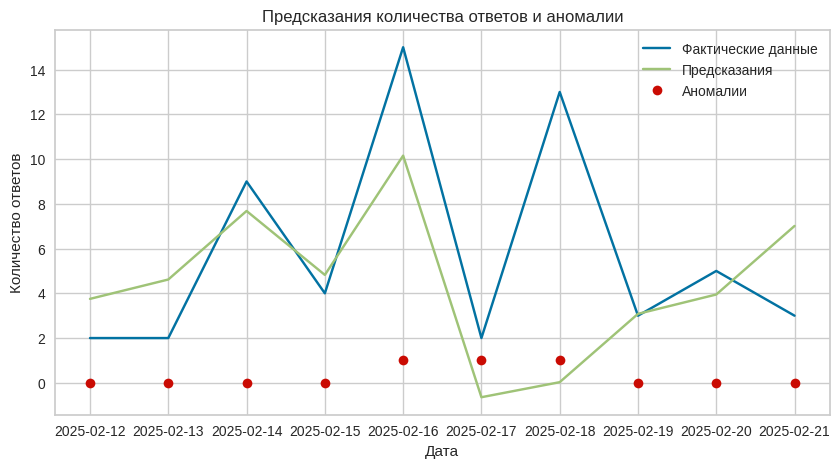

In [277]:
# График фактических значений, предсказаний и аномалий
plt.figure(figsize=(10, 5))
plt.plot(test.index, test['answer_count'], label='Фактические данные')
plt.plot(test.index, predictions_best, label='Предсказания')
plt.plot(anomalies.index, anomalies['Anomaly'], 'ro', label='Аномалии')
plt.xlabel('Дата')
plt.ylabel('Количество ответов')
plt.title('Предсказания количества ответов и аномалии')
plt.legend()
plt.show()

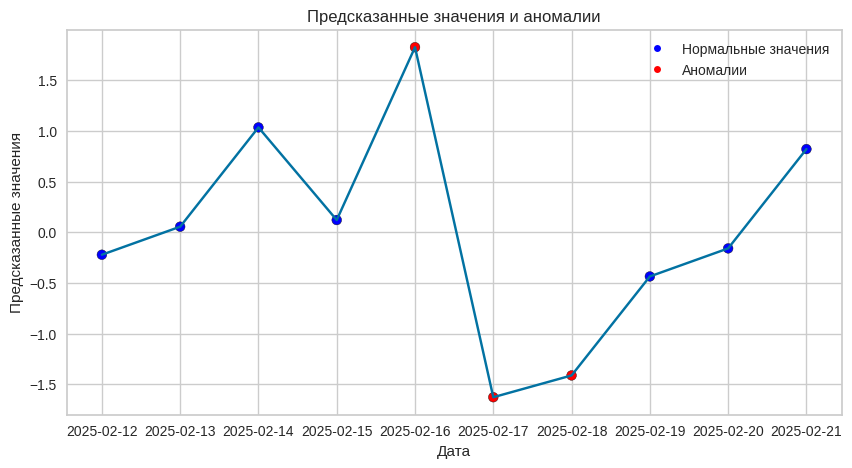

In [278]:
# График предсказанных значений и аномалий
plt.figure(figsize=(10, 5))

# Линия предсказанных значений
plt.plot(anomalies.index, anomalies['y_pred'], label='Предсказанные значения')

# Точки аномалий, выделенные цветом
colors = {0: 'blue', 1: 'red'}
plt.scatter(anomalies.index, anomalies['y_pred'], c=anomalies['Anomaly'].apply(lambda x: colors[x]), label='Аномалии', edgecolor='k')

# Оси и заголовок
plt.xlabel('Дата')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения и аномалии')

# Легенда с подробной информацией
blue_patch = plt.Line2D([0], [0], color='blue', marker='o', linestyle='None', markersize=5, label='Нормальные значения')
red_patch = plt.Line2D([0], [0], color='red', marker='o', linestyle='None', markersize=5, label='Аномалии')

plt.legend(handles=[blue_patch, red_patch])

plt.show()